## 0. CURE(Clustering-Using-REpresentatives) 알고리즘 ##

 - n 개의 군집으로 나눈다고 가정했을때 각각의 그룹에서 대표점을 c개를 뽑는다.
 - 대표점들로부터 각 군집의 centroid로 20%씩 이동시키면서 대표점을 수정하여 선택한다.

 - 목표 군집
 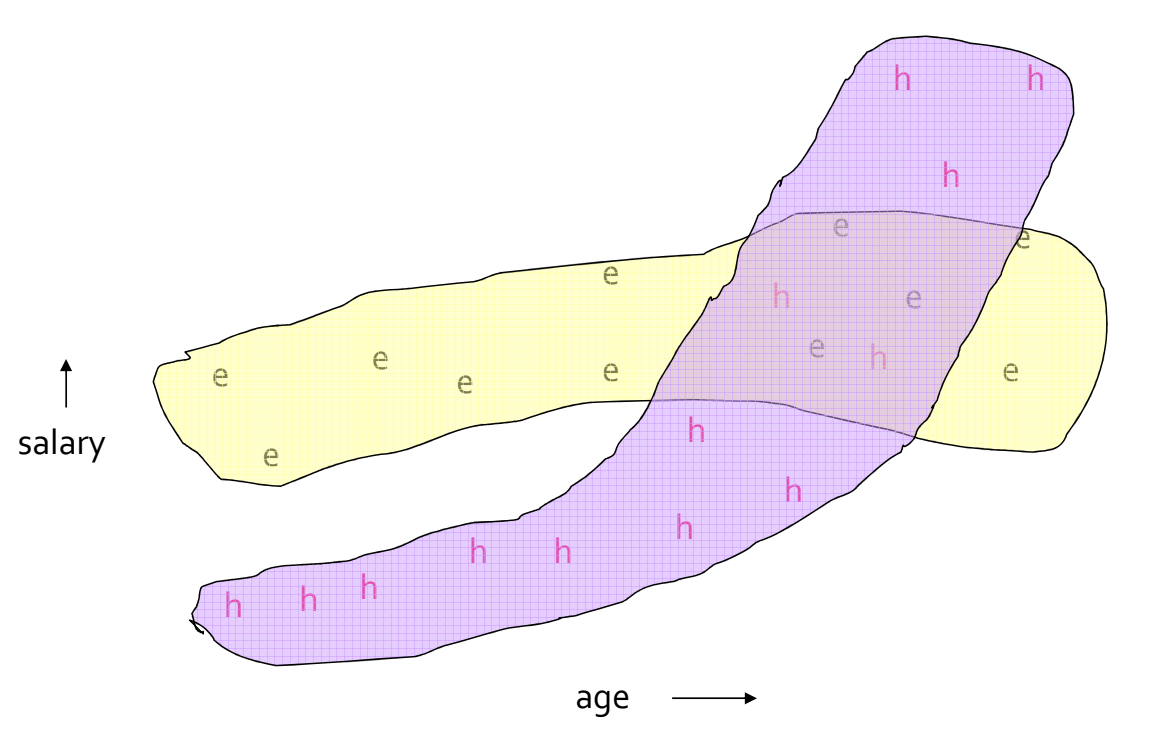

 - 초기 그룹화
 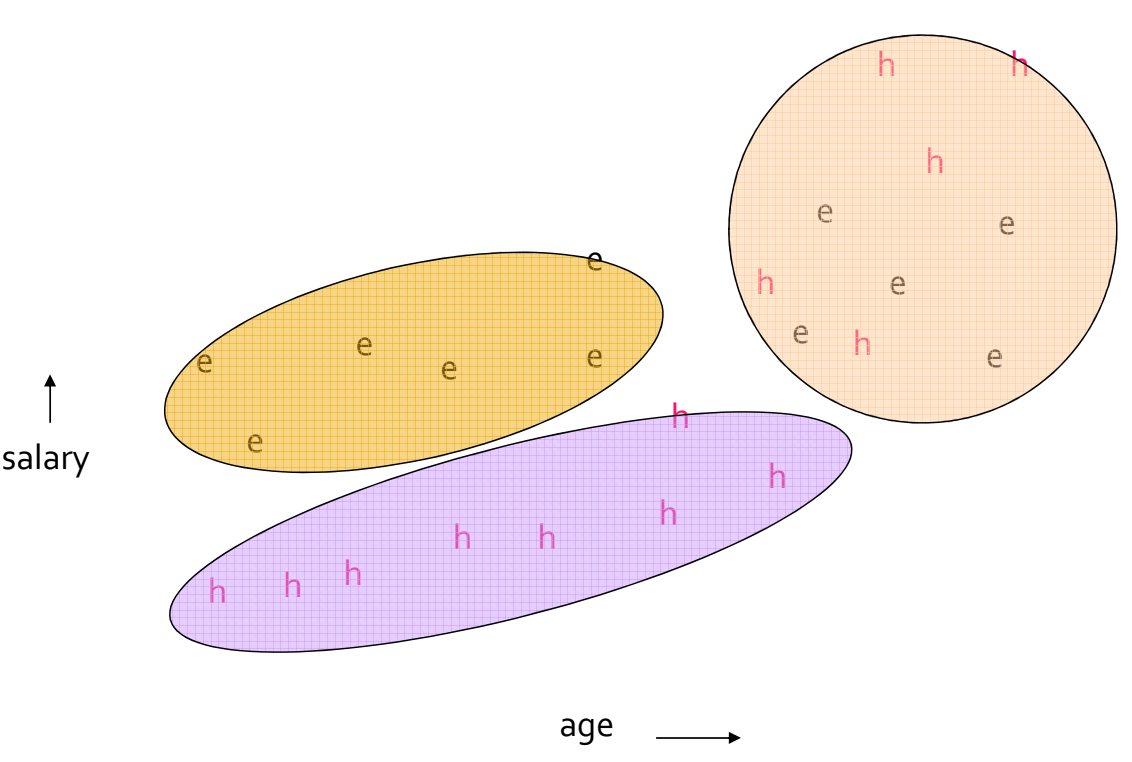

 - c를 4로 설정
 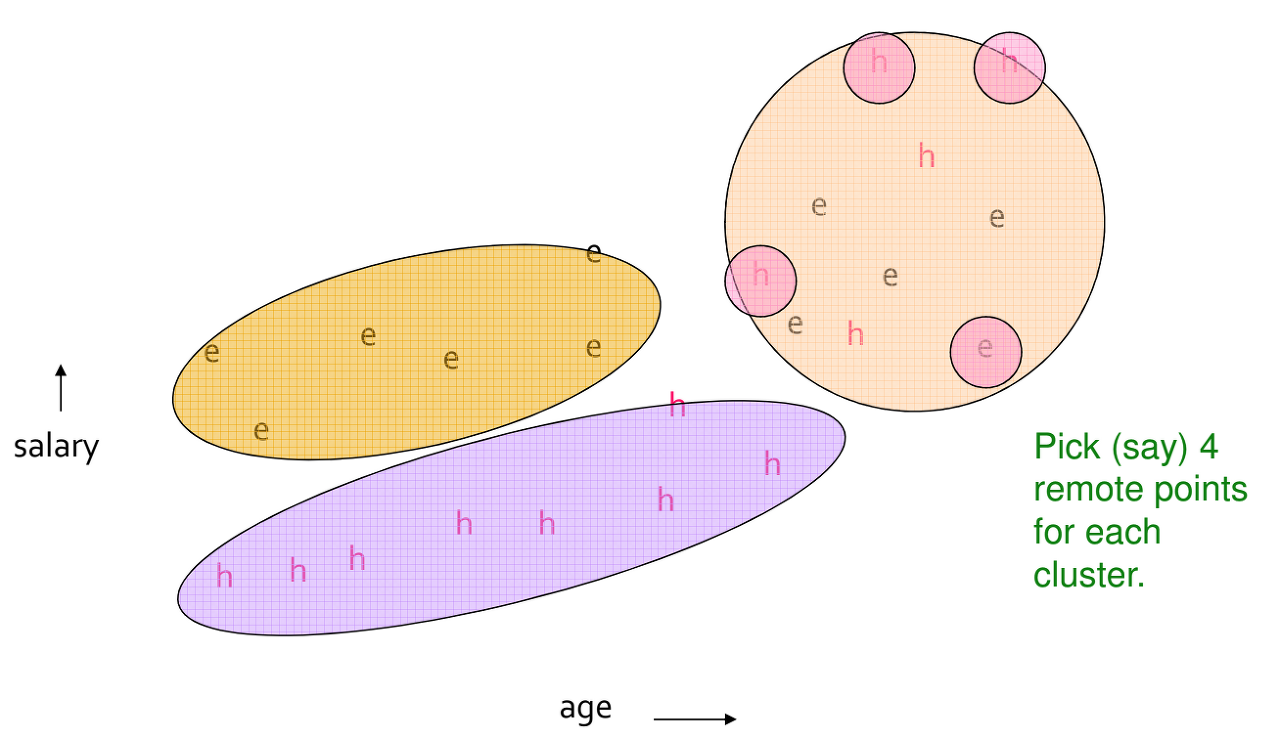

 - centroid를 20%씩 옮기며 중심점 재설정
    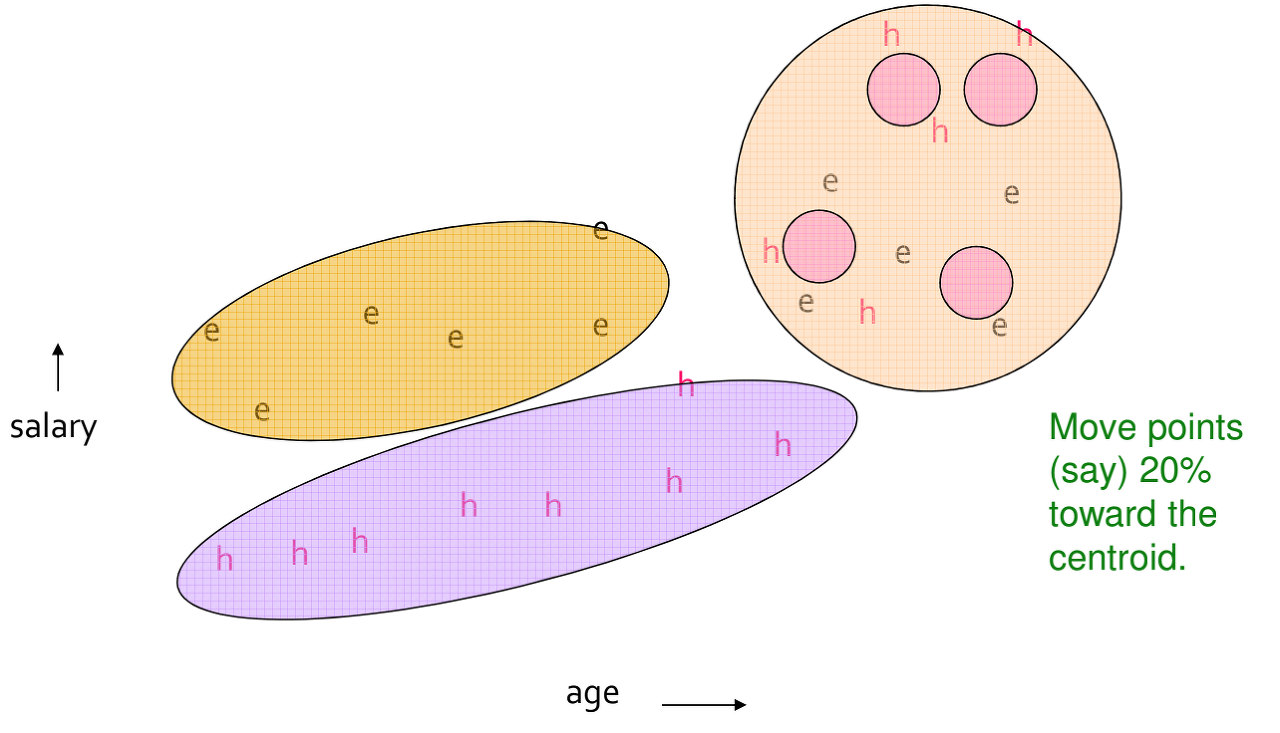

 - 특성  
    유클리디안 거리를 가정  
    어떤 모양이든 클러스터링이 가능  
    클러스터를 표현하기 위해 대표적인 점들을 수집  
    사이즈나 모양이 정규분포가 아닌 점들에 대해서도 군집화 가능  
    군집을 필요 이상의 개수로 나누지 않을 수 있음  
    여러 군집 기술을 복합적으로 사용 (유클리디안 + c개의 점 만들기)

## 1. import library and data ##

In [1]:
# 파이썬 기본 패키지
import math  # 수학 함수 패키지
import itertools  # Functions creating iterators for efficient looping
from collections import Counter  # label별 데이터 카운트를 위한 모듈

# 데이터 핸들링을 위한 패키지
import numpy as np
import pandas as pd

# 전처리 및 모델 성능평가 관련 패키지
from sklearn.preprocessing import *  # 데이터 전처리를 위한 패키지
from sklearn.model_selection import *  # 데이터 분리, 검증 및 파라미터 튜닝을 위한 패키지
from sklearn.metrics import *  # 모델에 대한 다양한 성능 평가를 위한 패키지

# 시각화를 위한 패키지
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # 내장 colormap, colormap 처리 유틸리티
from matplotlib.colors import ListedColormap  # colors and colormaps
%matplotlib inline
# %matplotlib inline 의 목적은 plt.show()함수가 호출되지 않은 경우에도 matplotlib 다이어그램을 렌더링하는 것이다.
# 그러나 현재 업데이트된 버전의 주피터 노트북 버전에서는 %matplotlib inline 를 사용하지 않더라도 Matplotlib 다이어그램을 개체로 표현한다.
# 따라서 굳이 필요하지는 않다. 그러나 코드를 깨끗하게 유지하고 자신이 만든 플롯을 호출하기 위해 여전히 관례적으로 권장된다.

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# 그래프 스타일 서식 지정
plt.style.use('default')

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 그래프 축의 음수 표현 오류 방지
plt.rcParams['axes.unicode_minus'] = False
#
####################################################################################

# scikit-learn 패키지
from sklearn.cluster import *  # 비지도 군집화 알고리즘 제공
from sklearn.mixture import *  # 혼합분포군집(GMM 등) 알고리즘 제공

from sklearn.decomposition import *  # 차원축소 알고리즘 제공
from sklearn.feature_selection import *  # 알고리즘에 큰 영향을 미치는 feature를 우선순위대로 선택하는 기능 제공
from sklearn.pipeline import *  # feature 처리 등의 변환과 ML 알고리즘 학습/예측 등을 함께 묶어서 실행하는 유틸리티 제공
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as shc
import seaborn as sns
from sklearn.metrics import confusion_matrix
from pyclustering.cluster.cure import cure
from pyclustering.cluster import cluster_visualizer

In [2]:
dr = pd.read_csv("bank_train.csv")

In [3]:
df = dr
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [4]:
df = df.iloc[:1000,:]
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


## 2. EDA

In [5]:
df.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                1
CustGender                 1
CustLocation               0
CustAccountBalance         1
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

 - na값이 적은 관계로 모두 삭제
 - trnasactionID, customerID Column 삭제

In [6]:
df = df.dropna(axis=0)
df = df.drop(["TransactionID", "CustomerID"], axis=1)

In [7]:
# Object 형태의 Data 분포 확인 #
df1 = df.select_dtypes(exclude='float')
for c in df1.columns:
    print ("---- %s ---" % c)
    print (df1[c].value_counts())

---- CustomerDOB ---
1/1/1800    63
26/12/88     3
2/2/90       3
2/12/86      3
8/3/92       2
            ..
1/10/90      1
2/5/70       1
2/3/87       1
12/7/82      1
4/12/89      1
Name: CustomerDOB, Length: 865, dtype: int64
---- CustGender ---
M    732
F    265
Name: CustGender, dtype: int64
---- CustLocation ---
MUMBAI                               109
BANGALORE                             83
NEW DELHI                             79
DELHI                                 69
GURGAON                               56
                                    ... 
GARDEN CHOWK PIMPLE SAUDAGAR PUNE      1
ADIPUR                                 1
ANDHERI W MUMBAI                       1
HOWRAH                                 1
ARIYALUR DISTRICT                      1
Name: CustLocation, Length: 258, dtype: int64
---- TransactionDate ---
21/10/16    781
9/8/16       31
6/8/16       28
3/8/16       26
1/8/16       24
4/8/16       23
7/8/16       22
5/8/16       18
12/8/16      16
2/8/16      

Column 별 조치사항  

TransactionDate : 연/월이 같으므로 일만 남김  
TransactionTime : 5자리 인건 앞에 한자리, 6자리인건 앞에 두자리만 시간으로 남기기  
CustomerDOB : 뒤에 2글자만 남기고 121에서 빼서 나이 구하기

## 2. 데이터 정리 ##

In [8]:
df["TransactionDate"] = df["TransactionDate"].astype(str).str[-2:]

In [9]:
df['TransactionTime'] = df['TransactionTime'].astype('str')
mask = df["TransactionTime"].str.len() == 5
df["TransactionTime"][mask] = '0'+ df["TransactionTime"][mask].astype(str)
df["TransactionTime"] = df["TransactionTime"].astype(str).str[:2]
df["TransactionTime"] = df["TransactionTime"].astype(int)

In [10]:
df['CustomerDOB'] = df['CustomerDOB'].astype('str')
df["CustomerDOB"] = df["CustomerDOB"].astype(str).str[-2:]
df["CustomerDOB"] = df["CustomerDOB"].astype(int)
df["CustomerDOB"] = 121 - df["CustomerDOB"]

In [11]:
# Labeling
object_col = ["CustGender", "CustLocation", "TransactionDate"]

LE=LabelEncoder()
for i in object_col:
    df[i]=df[[i]].apply(LE.fit_transform)

In [12]:
df.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27,0,99,17819.05,0,14,25.0
1,64,1,102,2270.69,0,14,27999.0
2,25,0,142,17874.44,0,14,459.0
3,48,0,142,866503.21,0,14,2060.0
4,33,0,151,6714.43,0,18,1762.5


## 3. CURE Clustering ##

In [13]:
df1 = df.values.tolist()
cure_instance = cure(df1, 5);
cure_instance.process();
clusters = cure_instance.get_clusters();

In [34]:
df["cure"] = 0
for i in range(0,5) : 
    df["cure"].iloc[clusters[i]] = i+1

In [35]:
df["cure"].value_counts()

3    965
2     18
1     10
5      3
4      1
Name: cure, dtype: int64

<AxesSubplot:xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

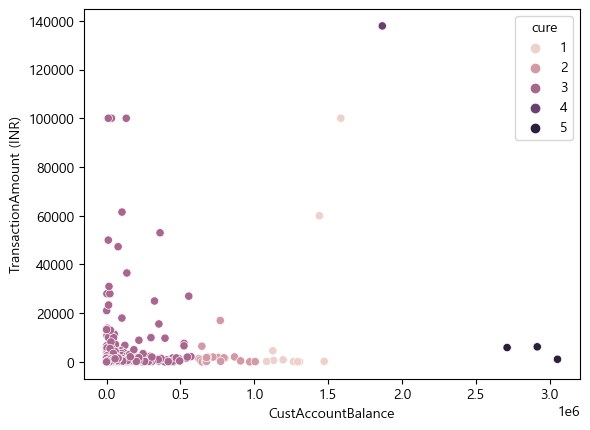

In [36]:
sns.scatterplot(x = 'CustAccountBalance', y = 'TransactionAmount (INR)', hue = 'cure', data = df)